In [9]:
%pylab inline
import scipy as sp
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [10]:
@jit
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [11]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

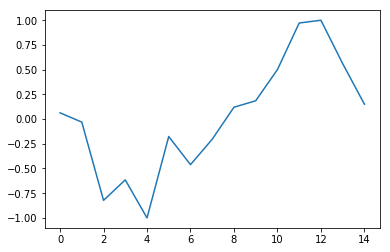

In [12]:
#plot(np.tanh(np.random.randn(10)))
def makeRandomWalk(len):
    pt = zeros(len)
    pt[0] = np.random.randn(1)
    for n in range(pt.size-1):
        pt[n+1] = pt[n] + np.random.randn(1)
    pt = pt - np.min(pt)
    pt = (pt / np.max(pt) * 2) - 1
    return pt
    

#plot()
plot(makeRandomWalk(15))

[ 0.18764671 -2.03868648]


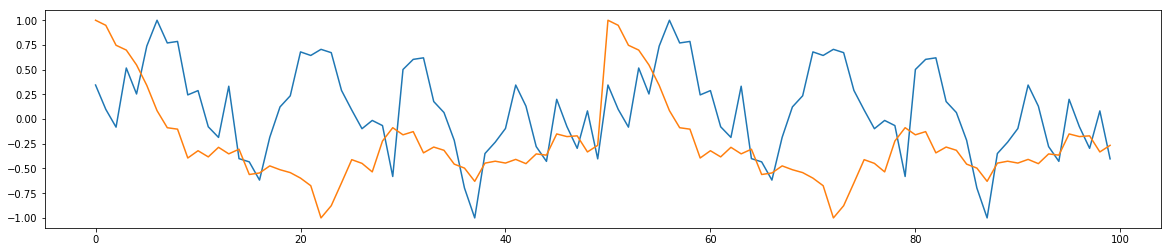

In [746]:
figsize(20,4)
# pSaw = lambda n: (round(n % waveLengthSamples) / waveLengthSamples * 2) - 1.0
# plot([pSaw(x) for x in arange(300)])
# pPulse = lambda n: (((n % waveLengthSamples) < (waveLengthSamples * 0.5)) * 2) - 1.0
# plot([pPulse(x) for x in arange(300)])
# pSine2 = lambda n: (sin(n) * sin((n+pi/4)/6))
# plot([pSine2(x) for x in arange(100)])
# pSine3 = lambda n: (sin(n) * sin((n/4)/6)/6)
# plot([pSine3(x) for x in arange(100)])

pJ1 = lambda n: 1 * sin(2 * pi * n / 3.1504531)
# plot([pJ1(x) for x in arange(100)])
pJ1b = lambda n, d: 1 * sin(n/d) ** 1
# plot([pJ1b(x,2) for x in arange(100)])

period2 = 2
rawp = np.random.randn(period2)
# rawp = np.array([1.1929,2.6856]);
maxVal = np.max(rawp)
minVal = np.min(rawp)
print(rawp)
rp = 0.5 * (2 * (rawp - minVal) / (maxVal - minVal) - 1);
pJ2 = lambda n: rp[mod(n, period2 )]
# plot([pJ2(x) for x in arange(100)])

#pTri = lambda n,p: (n % (p/2)) * ((n % p) > 0.5)
# pTri = lambda n,p: ((((n % p) >= (p/2)) * ((p/2) - (n % (p/2))) + ((n % p) < (p/2)) * (n % (p/2))) * (2/p)) * 2 -1
# #pTri = lambda n,p: (n % (p/2))
# plot([pTri(x,10) for x in arange(100)])

patternLength = 50
p_rw1 = makeRandomWalk(patternLength)
p_rw2 = makeRandomWalk(patternLength)
pLoop = lambda n,p: p[n%p.size]
plot([pLoop(x,p_rw1) for x in arange(100)])
plot([pLoop(x,p_rw2) for x in arange(100)])


0
Loading pattern  0
Loading pattern  1
NRMSE readout:  8.08860710484e-05
absSize readout:  0.0220599932132
NRMSE W:  0.00827035604307
absSize W:  1.8063605471
1
Loading pattern  0
Loading pattern  1
NRMSE readout:  0.000100160022346
absSize readout:  0.0213943935564
NRMSE W:  0.0290173970784
absSize W:  3.20283639274
2
Loading pattern  0
Loading pattern  1
NRMSE readout:  0.00020156981999
absSize readout:  0.0275996992301
NRMSE W:  0.0558475315843
absSize W:  4.12688764649
3
Loading pattern  0
Loading pattern  1
NRMSE readout:  8.63036293619e-05
absSize readout:  0.0212414605683
NRMSE W:  0.017316924112
absSize W:  1.97865431467
4
Loading pattern  0
Loading pattern  1
NRMSE readout:  6.66020799426e-05
absSize readout:  0.0196336892034
NRMSE W:  0.0157337312997
absSize W:  2.16287869734
NRMSEs: best:  0.00827035604307 avg:  0.0252371880235
Computing conceptors, alphas:  [ 75.62969246  54.49529277]
Computing conceptors, alphas:  [ 40.0345428   68.96655027]
Computing conceptors, alphas: 

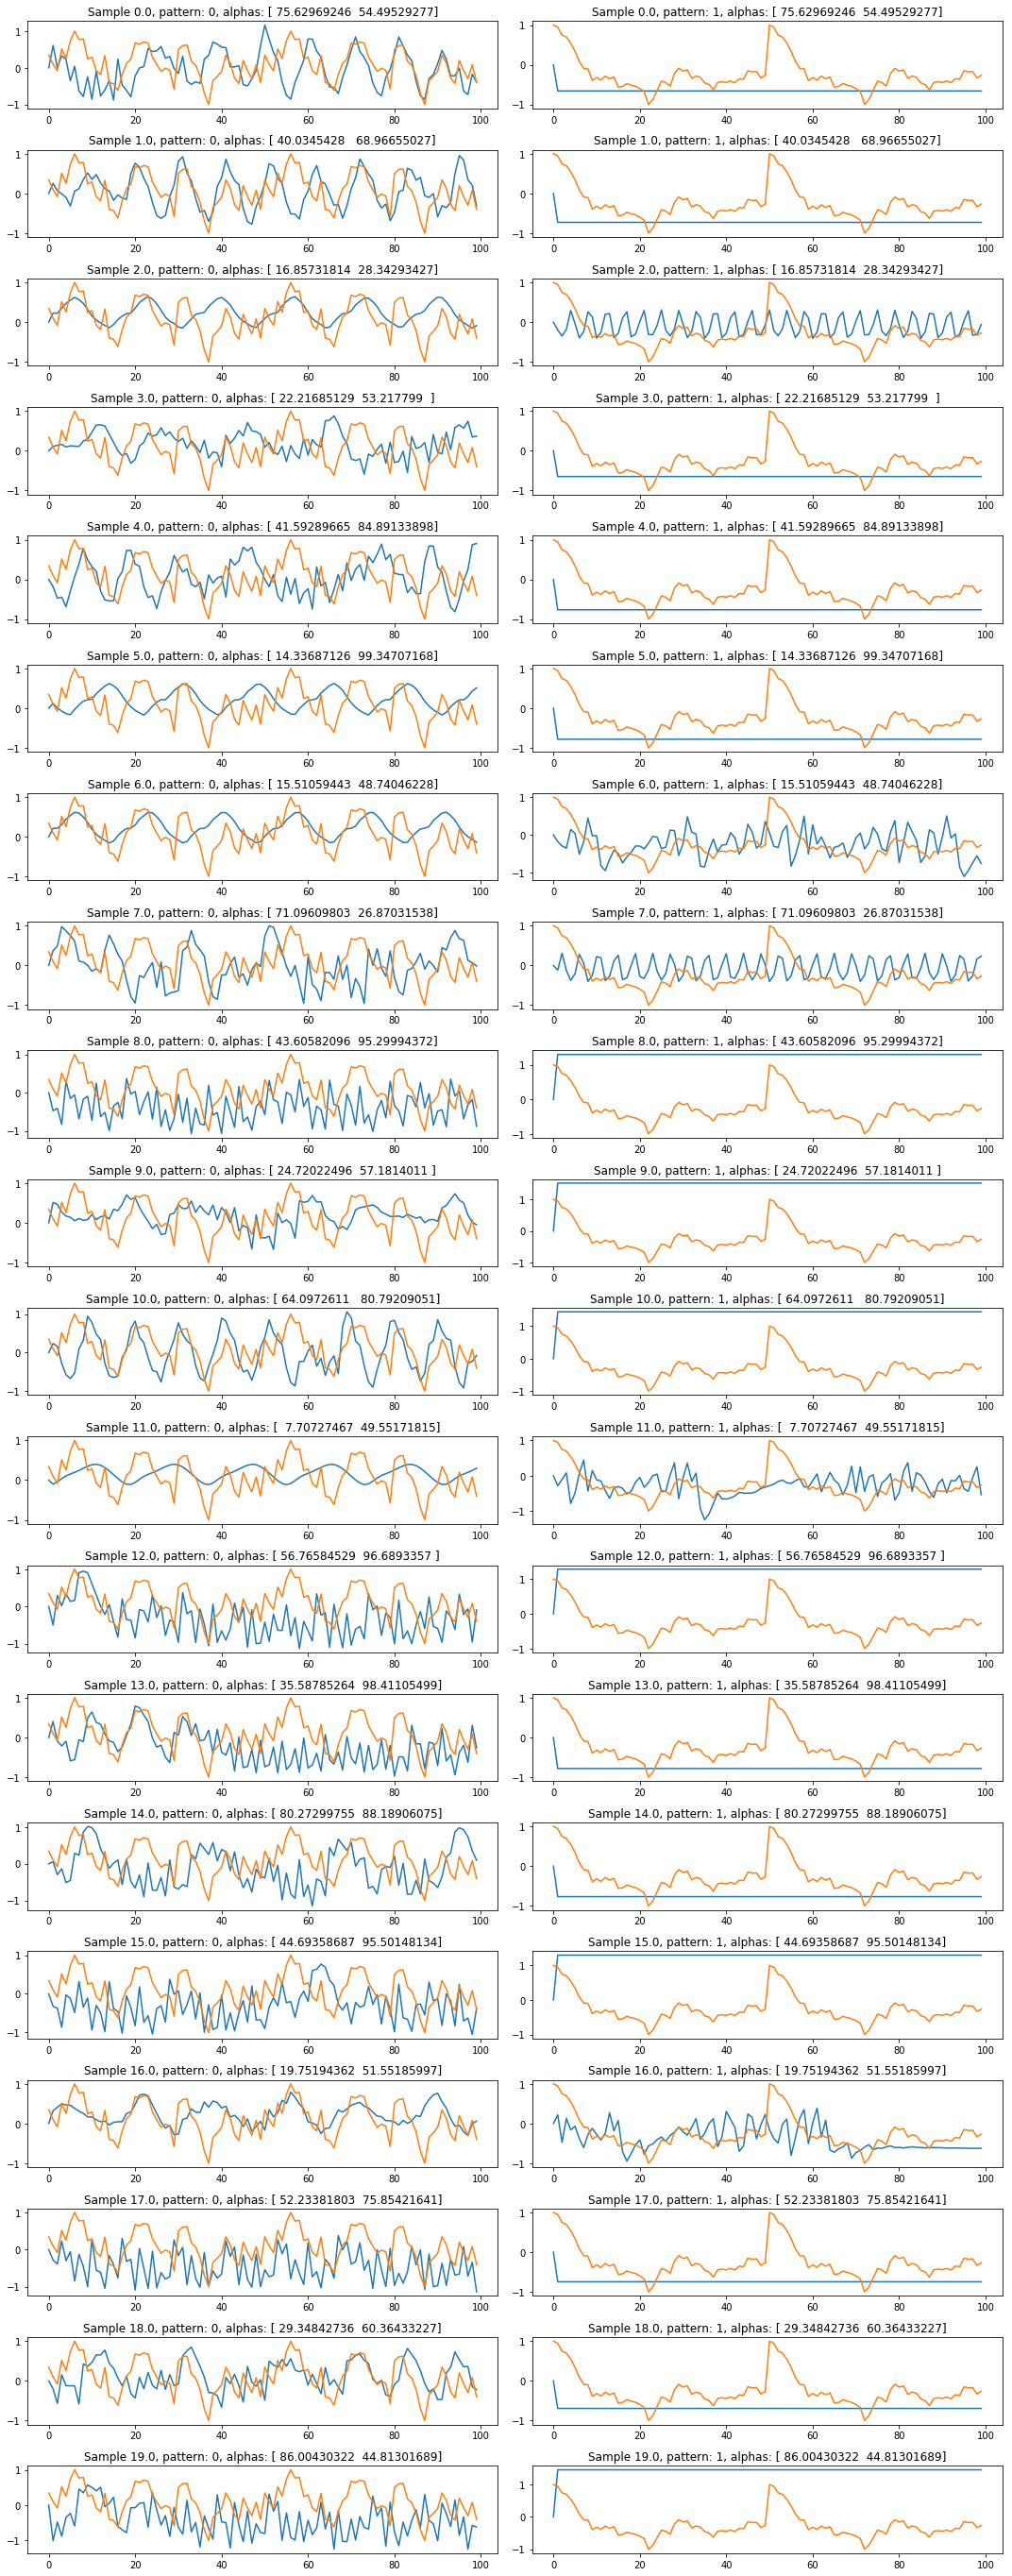

In [770]:

def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLengthWout']))
    pCollector = np.zeros((1, p['learnLengthWout']))
    x = np.zeros((p['N'],1))
    
    totalDataLength = p['learnLength'] * p['patts'].size
    totalLearnLength = totalDataLength - (p['patts'].size * p['washoutLength']); 
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    
    for i_pattern in range(p['patts'].size):
        print('Loading pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("NRMSE readout: ", NRMSE_readout)
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W)
    print("absSize W: ", absSize_W)

    return locals()

    
# #     figure(fig+1)
# #     plot(np.mean(W.dot(allTrainOldArgs).T, axis=1))

def computeConceptors(p, net, alphas):
    print('Computing conceptors, alphas: ', alphas)
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = net['patternRs'][0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)
    return locals()
            
def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
    x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    for i_pattern in range(p['patts'].size):
        C = cNet['Cs'][0,i_pattern]
        x = 0.5 * np.random.randn(p['N'],1)
        for n in range(recallTestLength + p['washoutLength']):
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
#             x = np.tanh(cNet['net']['W'].dot(x) + cNet['net']['Wbias']).dot(1.0 - p['leakRate']) + (xPrev.dot(p['leakRate'] ))
            x = C.dot(x)
            xPrev = x
            if (n > p['washoutLength']):
#                 x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
                p_CTestPL[:,n-p['washoutLength'],i_pattern] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    for i_pattern in range(p['patts'].size):
        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) + ", alphas: " + str(cNet['alphas']))
        plot(p_CTestPL[:,:,i_pattern].T)
        plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        

    
params = {'N':200, 'NetSR':0.99, 'NetinpScaling':1.9,'BiasScaling':0.8,'TychonovAlpha':0.0001,
         'washoutLength':300, 'learnLength':100, 'TychonovAlphaReadout':0.0001,
          'LR': 0.9,
         'learnLengthWout':100, 
          'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
#          'patts':np.array([pJ1, pJ2])
         }

# makeLoadedNetwork_v2(params)

sampleSize = 5
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_W'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], "avg: ", np.mean(nrmses) )

conceptorSampleSize = 20
conceptorNets = np.zeros(conceptorSampleSize, dtype=np.object)
figsize(15,conceptorSampleSize * 1.9)
for i_cnet in range(conceptorSampleSize):
    conceptorNets[i_cnet] = computeConceptors(params, loadedNets[bestNetwork], np.random.random(2) * 100)
    plotConceptorPatterns(params, conceptorNets[i_cnet], conceptorSampleSize, i_cnet * 2, 100)
plt.tight_layout();


Computing conceptors, alphas:  [ 41.  49.]


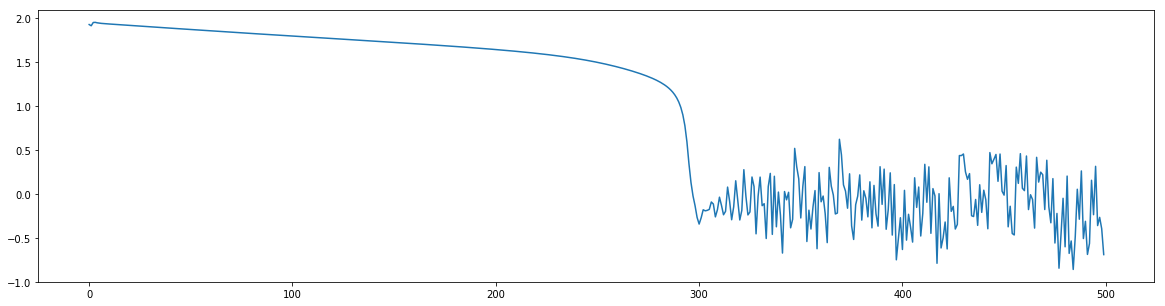

In [779]:
#run a network
cnet2 = computeConceptors(params, loadedNets[bestNetwork], np.array([41.0,49.0]))
figsize(20,5)
runLength = 500
output = np.zeros(runLength)
x = 0.5 * np.random.randn(cnet2['p']['N'],1)
for n in range(runLength):
    pos = ((n / runLength * 2) - 1.0) * 1
    C = (cnet2['Cs'][0,0].dot(pos)) + (cnet2['Cs'][0,1].dot((1.0-pos))) 
#    C = (net['Cs'][0,0] * 0.5) + (net['Cs'][0,1] * 0.5)
#     C = cnet2['Cs'][0,0]
    Wsr = cnet2['net']['W'].dot(1.0)
    
    for i_oversample in range(1):
        Wtarget = Wsr.dot(x)
        xOld = x
        x = ((1.0-cnet2['p']['LR']) * xOld) + (cnet2['p']['LR'] * tanh(Wtarget + cnet2['net']['Wbias']))
#         x = np.tanh(Wsr.dot(x) + cnet2['net']['Wbias'])
        x = C.dot(x)
    #x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
    output[n] = cnet2['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
plot(output)

In [780]:
import datetime
str(datetime.datetime.timestamp(datetime.datetime.now()))

1505238583.837115

In [ ]:
import dill as pickle
ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
with open(r"models/net_" + ts + ".pickled", "wb") as output_file:
    pickle.dump(cnet2, output_file, protocol=0)

In [710]:
def createGeneratorState(net):
    return {
        'x':0.5 * np.random.randn(net['p']['N'],1),
        'xOld':np.zeros((net['p']['N'],1)),
        'output':0.0
    }

def iterateGenerator(net, state, mixArray, excitation):
    #conceptor mix
#     C = (net['Cs'][0,0].dot(mix1)) + (net['Cs'][0,1].dot((mix2))) 
    C = np.zeros_like(net['Cs'][0,0])
    for i_morph, morph in enumerate(mixArray):
        C = C + (net['Cs'][0,i_morph].dot( morph ))
    #excitation
    Wsr = net['net']['W'].dot(excitation)    
    #update reservoir
    state['xOld'] = state['x']
    Wtarget = Wsr.dot(state['x'])
    state['x'] = ((1.0-net['p']['LR']) * state['xOld']) + (net['p']['LR'] * tanh(Wtarget + net['net']['Wbias']))
    #apply mixed conceptor
    state['x'] = C.dot(state['x'])
    #compute output layer
    state['output'] = net['net']['Wout'].dot(np.concatenate((state['x'][:,0], np.array([1]))))
    return state
    

In [331]:
state = createGeneratorState(cnet2)
print(state.keys())

dict_keys(['x', 'xOld', 'output'])


In [703]:
state = iterateGenerator(cnet2, state, np.array([0.0, 1.0]), 1.0)
print(state['output'])

[ 0.59537594]


In [134]:
xCollector[0:-1]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [293]:
cn

NameError: name 'cn' is not defined

In [324]:
for i,v in enumerate(np.arange(10)+10):
    print (i,v)

0 10
1 11
2 12
3 13
4 14
5 15
6 16
7 17
8 18
9 19
